In [25]:
from __future__ import division

import os

import csv
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import pandas as pd
import datetime
import pytz

import seaborn as sns
%matplotlib inline

from datetime import date, timedelta, datetime
from pytz import timezone
from dateutil.tz import tzutc, tzoffset
from dateutil import tz
from pandas.tseries.offsets import *
from pandas import *

from scipy import stats

# Meters for each building in each catogory

In [2]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('US/Eastern')

In [3]:
DAH = ['WA_12_EL_BL_997_2', 'WA_12_EL_BL_997_1', 'WA_12_EL_BL_221_2',
       'WA_12_EL_BL_221_1', 'WA_12_EL_BL_182_2', 'WA_12_EL_BL_182_1',
       'WA_12_EL_BL_1500_3', 'WA_12_EL_BL_1500_2', 'WA_12_EL_BL_1500_1',
       'WA_12_EL_BL_135_2', 'WA_12_EL_BL_135_1', 'WA_12_EL_BL_121_2',
       'WA_12_EL_BL_121_1', 'WA_12_EL_BL_120M_1', 'WA_12_EL_BL_1200_3',
       'WA_12_EL_BL_1200_2', 'WA_12_EL_BL_1200_1']

WNY = ['WA_02_EL_BL_58_1']

JBAB = ['WA_03_EL_BL_417_2','WA_03_EL_BL_417_1', 'WA_03_EL_BL_3623_2', 'WA_03_EL_BL_21_1',
        'WA_03_EL_BL_1_1', 'WA_03_EL_BL_15_B_2', 'WA_03_EL_BL_15_A_1',]

Note: Original timestep is UTC, need to convert it to local time zone: UTC-05:00

In [4]:
TechOffice = [s for s in DAH if "BL_121" in s]
BowlingCenter_135 = [s for s in DAH if "BL_135" in s]
Building_182 = [s for s in DAH if "BL_182" in s]

In [5]:
# consider the holidays
holidays = pd.read_csv('holiday.csv', usecols=[0])
holidays['date'] = pd.to_datetime(pd.Series(holidays['date']), format='%m/%d/%y')
holidays['day'] = holidays.date.apply(lambda x: x.strftime('%Y-%m-%d'))

def MeterData_Format(data):
    data['date'] = data.index
    data['power'] = data[[col for col in data.columns if "WA" in col]].sum(axis=1)
    data['day'] = map(lambda x: x.strftime('%Y/%m/%d'),data.index)
    data['time'] = map(lambda x: x.strftime('%H:%M'),data.index)
    data['month'] = map(lambda x: x.strftime('%m'),data.index)
    data['hour'] = map(lambda x: x.strftime('%H'),data.index)
    data['month'] = data.month.astype(int)
    data['hour'] = data.hour.astype(int)
    data['weekday'] = data.index.weekday
    data['holiday'] = map(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values,data.index)
    data['holiday'] = data.holiday.astype(int)
    
    return data

In [6]:
def MergeMeterID(MeterID):
    df = pd.read_csv('../meter/' + MeterID + '.csv')
    df.index = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S') + timedelta(hours=-5))
    df.columns = ['date',MeterID]
    df.drop(df.columns[[0]],axis=1,inplace=True)
    
    return df

In [12]:
def CleanMeterData(BuildingID,weather):
    dfs = [MergeMeterID(MeterID) for MeterID in BuildingID]
    data = pd.concat(dfs,axis=1)
    data = MeterData_Format(data)
    
    df = pd.concat([data,weather],axis=1,join_axes=[data.index])

    # calculate basepower on weekdays
    df.loc[:,'basepower'] = 0
    df.loc[:,'peakoat'] = 0

    # calculate the daily peak OAT
    PeakOAT = df.groupby(['day'])['oat'].max()

    for day in PeakOAT.index:
        df.loc[(df['day'] == day),'peakoat'] = PeakOAT[day]

    # subset the weekday and weekend power
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]

    # calculate the basepower on weekdays and weekend
    df_wd_base = df_wd.loc[(df_wd['oat'] < 68)]
    df_wd_basedaily = df_wd_base.pivot(index='time',columns='day',values='power')
    df_wk_base = df_wk.loc[(df_wk['oat'] < 68)]
    df_wk_basedaily = df_wk_base.pivot(index='time',columns='day',values='power')

    for tim in df_wd_basedaily.index:
        df.loc[(df['time'] == tim) & (df['weekday'] >= 0) & \
           (df['weekday'] <= 4) & (df['holiday'] == 0),'basepower'] = df_wd_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df.weekday.apply(lambda x: x in [5,6])),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df['holiday'] == 1),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]

    df.loc[:,'hvac'] = df.power - df.basepower
    
    return data, df

In [13]:
dfs = [MergeMeterID(MeterID) for MeterID in Building_182]
data = pd.concat(dfs,axis=1)
data = MeterData_Format(data)

In [14]:
weather = pd.read_csv('../weather/KVACOLON6.csv')
weather.columns = ['date','oat']
weather.index = weather['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M'))
weather.drop(weather[['date']],axis=1,inplace=True)
weather = weather.groupby(weather.index).first() # remove the duplicate index


## Create the entire dataset from meter data and weather data

In [15]:
data,df = CleanMeterData(Building_182,weather) 

In [17]:
df

,WA_12_EL_BL_182_2,WA_12_EL_BL_182_1,date,power,day,time,month,hour,weekday,holiday,oat,basepower,peakoat,hvac
date,,,,,,,,,,,,,,
2015-01-01 00:15:00,2.4,6.4,2015-01-01 00:15:00,8.8,2015/01/01,00:15,1,0,3,1,26.2,9.044828,46.3,-0.244828
2015-01-01 00:30:00,3.6,4.8,2015-01-01 00:30:00,8.4,2015/01/01,00:30,1,0,3,1,27.1,8.779487,46.3,-0.379487
2015-01-01 00:45:00,2.4,6.4,2015-01-01 00:45:00,8.8,2015/01/01,00:45,1,0,3,1,26.4,9.038655,46.3,-0.238655
2015-01-01 01:00:00,2.4,6.4,2015-01-01 01:00:00,8.8,2015/01/01,01:00,1,1,3,1,27.3,8.853333,46.3,-0.053333
2015-01-01 01:15:00,3.6,6.4,2015-01-01 01:15:00,10.0,2015/01/01,01:15,1,1,3,1,27.0,9.084298,46.3,0.915702
2015-01-01 01:30:00,2.4,6.4,2015-01-01 01:30:00,8.8,2015/01/01,01:30,1,1,3,1,27.3,8.922314,46.3,-0.122314
2015-01-01 01:45:00,3.6,6.4,2015-01-01 01:45:00,10.0,2015/01/01,01:45,1,1,3,1,26.9,8.953600,46.3,1.046400
2015-01-01 02:00:00,2.4,4.8,2015-01-01 02:00:00,7.2,2015/01/01,02:00,1,2,3,1,27.0,8.898361,46.3,-1.698361
2015-01-01 02:15:00,2.4,6.4,2015-01-01 02:15:00,8.8,2015/01/01,02:15,1,2,3,1,27.5,8.888525,46.3,-0.088525


10 baseline days
10 baseline days
10 baseline days


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


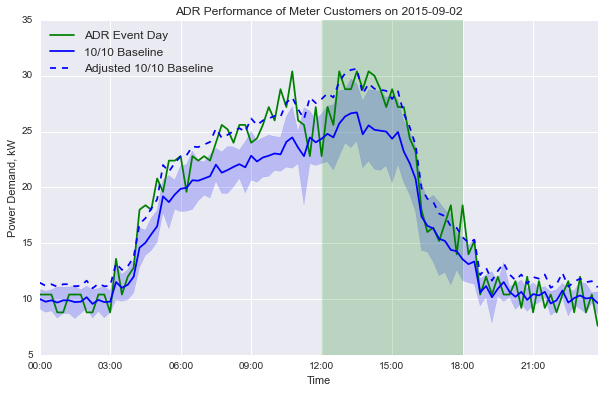

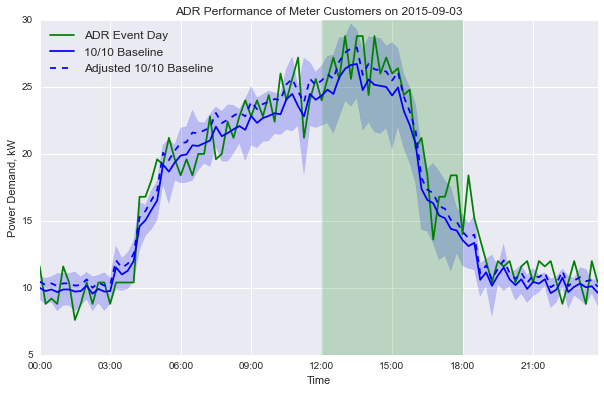

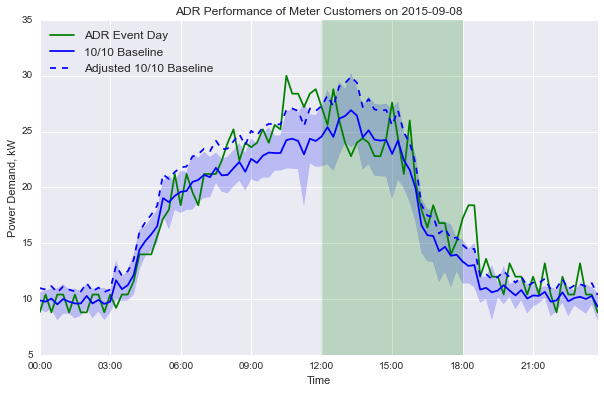

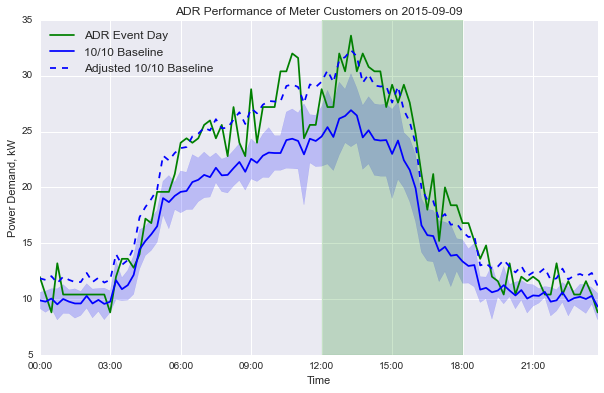

In [32]:
# Read the holiday and DR event days 
drevent = pd.read_csv('DR_Events_2015.csv', usecols=[3])
drevent['date'] = pd.to_datetime(pd.Series(drevent['date']), format='%m/%d/%y')
drevent['day'] = drevent.date.apply(lambda x: x.strftime('%Y-%m-%d'))

# offdays = pd.DataFrame.append(holidays, drevent)

# Sort DR event days' power use
data = df.copy()

data['year'] = data.date.apply(lambda x: x.strftime('%Y'))
data['time'] = data.date.apply(lambda x: x.strftime('%H:%M'))
data['month'] = data.date.apply(lambda x: x.strftime('%m'))
data['day'] = data.date.apply(lambda x: x.strftime('%d'))
data['hour'] = data.date.apply(lambda x: x.strftime('%H'))
data['minute'] = data.date.apply(lambda x: x.strftime('%M'))
data['weekday'] = data.date.apply(lambda x: x.strftime('%w'))
data['weekday'] = data.weekday.astype(int)
data['DR'] = data.date.apply(lambda x: x.strftime('%Y-%m-%d') in drevent.day.values)
data['DR'] = data.DR.astype(int)
data['holiday'] = data.date.apply(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values)
data['holiday'] = data.holiday.astype(int)

# weekdays for each baseline
data_wk = data[(data['weekday'] > 0) & (data['holiday']==0) & (data['weekday'] < 6)]
data_wk.to_csv('../results/Building182/data_wk.csv')

baseline_day = []
baseline = pd.DataFrame()

# kW shed
kW_shed = 5

# plot all ADR performance figures
ADR_Summary = pd.DataFrame()
# plot all ADR performance figures
i, j, k = 0, 1, 0
for k in range(4):
    
    j = 1
    baseline_day = []
    DayAverage = []
    baseline = pd.DataFrame()
    DR_Event = pd.DataFrame()
        
    for i in range(20):
        baseline_ref = drevent.date[k] - (i+1) * Day()
        if baseline_ref in data_wk.index:
            
            baseline_indicator = data_wk[baseline_ref.strftime('%Y-%m-%d')]['DR'][0]
            baseline_day_indicator = data_wk[baseline_ref.strftime('%Y-%m-%d')]['date'][0]
            if j <= 10:
                if baseline_indicator == 0:
                    j+=1
                    baseline_day = data_wk[baseline_ref.strftime('%Y-%m-%d')][['time','power']]
                    baseline_day.index = baseline_day['time']
                    baseline_day.columns = ['time',baseline_ref.strftime('%Y-%m-%d')]
                    baseline = pd.concat([baseline, baseline_day[baseline_ref.strftime('%Y-%m-%d')]],axis=1)
                    #baseline.index = data_wk[baseline_ref.strftime('%Y-%m-%d')]['time']
                    #baseline.append(baseline_day)
                elif baseline_indicator == 1:
                    pass
            else:
                print("10 baseline days")
                break
        else:
            continue
    
    baseline.to_csv('../results/Building182/Meter_Baseline_' + str(k) +'.csv')
    
    # Calculate the baseline days' load variability, standard deviation
    baseline['mean'] = baseline.mean(axis=1)
    baseline['std'] = baseline.std(axis=1)
    
    DR = data_wk[drevent.date[k].strftime('%Y-%m-%d')][['time','power']]
    DR.index = DR['time']
    DR['Virtual_DR'] = DR['power']
    DR['Virtual_DR']['12:15':'18:00'] = DR['Virtual_DR']['12:15':'18:00'] - kW_shed
    
    # Adjustment of baseline, from 10am to 1pm, no cap
    adj_factor = np.mean(DR['08:15':'11:00']['power'] / baseline['08:15':'11:00']['mean'])
    if adj_factor > 1.2:
        adj_factor = 1.2;
    elif adj_factor < -1.2:
        adj_factor = -1.2;
    
    # Create the ADR event day performance and two baselines
    DR_Event['baseline'] = baseline['mean']
    DR_Event['Adj_baseline'] = baseline['mean'] * adj_factor
    DR_Event['ADR'] = DR['Virtual_DR']
    DR_Event['kW_Shed'] = baseline['mean'] * adj_factor - DR['Virtual_DR']
    DR_Event['kWShed_Per'] = (baseline['mean'] * adj_factor - DR['Virtual_DR']) / (baseline['mean'] * adj_factor)
    DR_Event['var'] = baseline['std'] / baseline['mean']
    
    Min_kWShed = min(DR_Event['12:15':'18:00']['kW_Shed'])
    Max_kWshed = max(DR_Event['12:15':'18:00']['kW_Shed'])
    Ave_kWShed = np.mean(DR_Event['12:15':'18:00']['kW_Shed'])
    Min_kWShed_Per = min(DR_Event['12:15':'18:00']['kWShed_Per'])
    Max_kWShed_Per = max(DR_Event['12:15':'18:00']['kWShed_Per'])
    Ave_kWShed_Per = np.mean(DR_Event['12:15':'18:00']['kWShed_Per'])
    Ave_var = np.mean(DR_Event['09:15':'18:00']['var'])
    Ave_std = np.mean(baseline['12:15':'18:00']['mean']) * np.mean(DR_Event['12:15':'18:00']['var'])
    Ave_err = np.mean(abs(DR_Event['12:15':'18:00']['Adj_baseline'] - DR['12:15':'18:00']['power']))
    
    ADR_Summary['ADR'+ str(k)] =  [Min_kWShed,Max_kWshed,Ave_kWShed,Min_kWShed_Per,Max_kWShed_Per,Ave_kWShed_Per,Ave_var,Ave_std, Ave_err]
    #concat(ADR_Summary, DataFrame([Min_kWShed,Max_kWshed,Ave_kWShed,Min_kWShed_Per,Max_kWShed_Per,Ave_kWShed_Per],columns=['ADR'+str(k)]),axis=1)
    
    DR_Event.to_csv('../results/Building182/Test_ADR' + str(k) +'.csv')
    
    # Plot DR and average baseline with std
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), DR['power'],'g-', label='ADR Event Day')
#     ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), DR['Virtual_DR'],'r-', label='Virtual ADR Event Day')
    #ax.plot_date(DR1.index, DR1['power'],'b-')

    #ax.set_ylim(0,600)
    ax.set_xlabel('Time')
    ax.set_ylabel('Power Demand, kW')
    ax.set_title('ADR Performance of Meter Customers on ' + drevent.date[k].strftime('%Y-%m-%d'))
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean'],'b-', label='10/10 Baseline')
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean'] * adj_factor,'b--', label='Adjusted 10/10 Baseline')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax.axvspan(*mdates.datestr2num(['1900-01-01 12:00', '1900-01-01 18:00']), color='green', alpha=0.2)
    #ax.axvspan('15:00', '16:00', color='red', alpha=0.5)
    ax.fill_between(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean']-baseline['std'], baseline['mean']+baseline['std'], color='b', alpha=0.2)
    
    ax.legend(loc='upper left', shadow=False, fontsize=12)
    ax.grid(True)
    
    plt.savefig('../results/Building182/ADR Performance_' + drevent.date[k].strftime('%Y-%m-%d') + '.png', 
                dpi=300, bbox_inches='tight')
                
ADR_Summary.to_csv('../results/Building182/Test_ADR_Summary' +'.csv')

# Plot kW shed distribution
# Per_Expected = ADR_Summary.loc[2,:] / kW_shed
# Var = ADR_Summary.loc[3,:]

# plt.hist(Per_Expected, bins=10,normed=1)

# data_sorted = np.sort(Per_Expected)
# p = 1. * arange(len(Per_Expected)) / (len(Per_Expected)-1)
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(data_sorted, p)
# plt.show()

# fig, ax = plt.subplots(figsize=(10,6))
# ax.set_xlabel('Number of ADR Event Days')
# ax.set_ylabel('Per Expected')
# plt.bar(np.arange(len(Per_Expected)),Per_Expected,facecolor='blue', alpha=0.5)
# plt.savefig(path +'TRU Meter4/ADR Performance_Summary' + '.png', dpi=400, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(10,6))
# width = 0.35
# ax.set_xlabel('Number of ADR Event Days')
# ax.set_ylabel('kW Shed')
# plt.bar(np.arange(len(Per_Expected)),ADR_Summary.loc[2,:],width,facecolor='blue', alpha=0.5)
# plt.bar(np.arange(len(Per_Expected))+width,ADR_Summary.loc[7,:],width,facecolor='green', alpha=0.5)
# ax.legend(('Measured kW Shed','One Standard Deviation'), loc='upper left', shadow=False)

# l = plt.axhline(y=23,linewidth=2, color='r')
# ax.annotate('Approved kW Shed', xy=(2, 32))
# plt.savefig(path +'TRU Meter4/ADR Performance_kW_Summary' + '.png', dpi=400, bbox_inches='tight')

10 baseline days
10 baseline days
10 baseline days


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


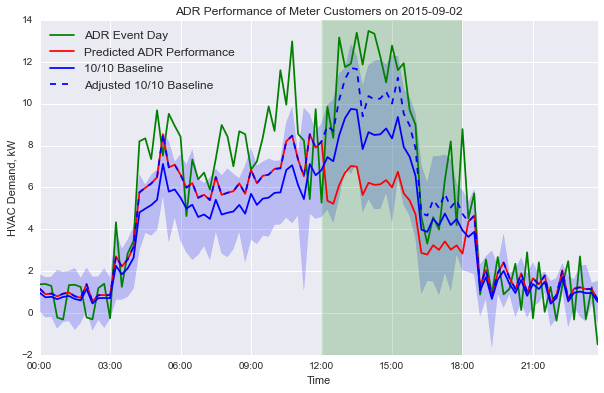

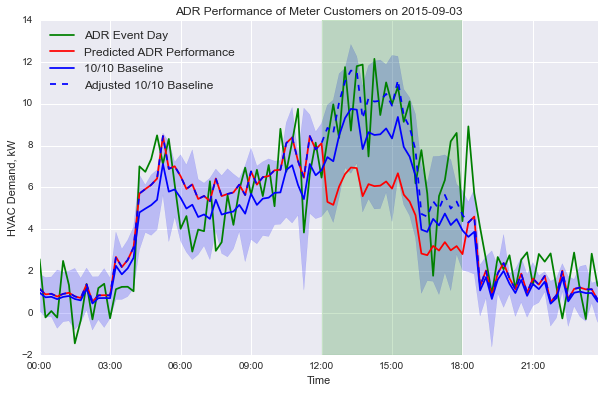

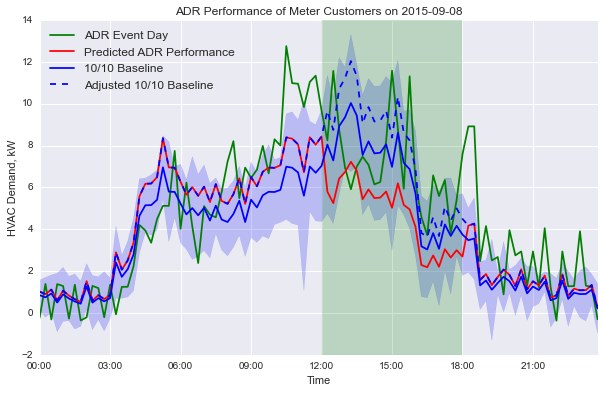

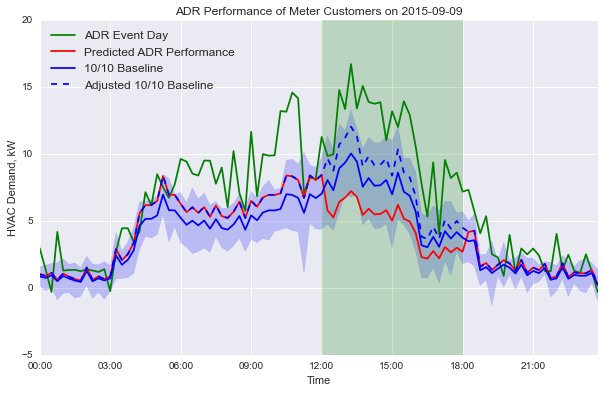

In [36]:
# Read the holiday and DR event days 
drevent = pd.read_csv('DR_Events_2015.csv', usecols=[3])
drevent['date'] = pd.to_datetime(pd.Series(drevent['date']), format='%m/%d/%y')
drevent['day'] = drevent.date.apply(lambda x: x.strftime('%Y-%m-%d'))

# offdays = pd.DataFrame.append(holidays, drevent)

# Sort DR event days' power use
data = df.copy()

data['year'] = data.date.apply(lambda x: x.strftime('%Y'))
data['time'] = data.date.apply(lambda x: x.strftime('%H:%M'))
data['month'] = data.date.apply(lambda x: x.strftime('%m'))
data['day'] = data.date.apply(lambda x: x.strftime('%d'))
data['hour'] = data.date.apply(lambda x: x.strftime('%H'))
data['minute'] = data.date.apply(lambda x: x.strftime('%M'))
data['weekday'] = data.date.apply(lambda x: x.strftime('%w'))
data['weekday'] = data.weekday.astype(int)
data['DR'] = data.date.apply(lambda x: x.strftime('%Y-%m-%d') in drevent.day.values)
data['DR'] = data.DR.astype(int)
data['holiday'] = data.date.apply(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values)
data['holiday'] = data.holiday.astype(int)

# weekdays for each baseline
data_wk = data[(data['weekday'] > 0) & (data['holiday']==0) & (data['weekday'] < 6)]
data_wk.to_csv('../results/Building182/data_wk.csv')

baseline_day = []
baseline = pd.DataFrame()

# kW shed
kW_shed = 5

# plot all ADR performance figures
ADR_Summary = pd.DataFrame()
# plot all ADR performance figures
i, j, k = 0, 1, 0
for k in range(4):
    
    j = 1
    baseline_day = []
    DayAverage = []
    baseline = pd.DataFrame()
    DR_Event = pd.DataFrame()
        
    for i in range(20):
        baseline_ref = drevent.date[k] - (i+1) * Day()
        if baseline_ref in data_wk.index:
            
            baseline_indicator = data_wk[baseline_ref.strftime('%Y-%m-%d')]['DR'][0]
            baseline_day_indicator = data_wk[baseline_ref.strftime('%Y-%m-%d')]['date'][0]
            if j <= 10:
                if baseline_indicator == 0:
                    j+=1
                    baseline_day = data_wk[baseline_ref.strftime('%Y-%m-%d')][['time','hvac']]
                    baseline_day.index = baseline_day['time']
                    baseline_day.columns = ['time',baseline_ref.strftime('%Y-%m-%d')]
                    baseline = pd.concat([baseline, baseline_day[baseline_ref.strftime('%Y-%m-%d')]],axis=1)
                    #baseline.index = data_wk[baseline_ref.strftime('%Y-%m-%d')]['time']
                    #baseline.append(baseline_day)
                elif baseline_indicator == 1:
                    pass
            else:
                print("10 baseline days")
                break
        else:
            continue
    
    baseline.to_csv('../results/Building182/Meter_Baseline_HVAC' + str(k) +'.csv')
    
    # Calculate the baseline days' load variability, standard deviation
    baseline['mean'] = baseline.mean(axis=1)
    baseline['std'] = baseline.std(axis=1)
    
    DR = data_wk[drevent.date[k].strftime('%Y-%m-%d')][['time','hvac']]
    DR.index = DR['time']
#     DR['Virtual_DR'] = DR['hvac']
#     DR['Virtual_DR']['12:15':'18:00'] = DR['Virtual_DR']['12:15':'18:00'] * 0.6
    
    # Adjustment of baseline, from 10am to 1pm, no cap
    adj_factor = np.mean(DR['08:15':'11:00']['hvac'] / baseline['08:15':'11:00']['mean'])
    if adj_factor > 1.2:
        adj_factor = 1.2;
    elif adj_factor < -1.2:
        adj_factor = -1.2;
    
    # Create the ADR event day performance and two baselines
    DR_Event['baseline'] = baseline['mean']
    DR_Event['Adj_baseline'] = baseline['mean'] * adj_factor
    DR_Event['ADR'] = DR['hvac']
    DR_Event['kW_Shed'] = baseline['mean'] * adj_factor - DR['hvac']
    DR_Event['kWShed_Per'] = (baseline['mean'] * adj_factor - DR['hvac']) / (baseline['mean'] * adj_factor)
    DR_Event['var'] = baseline['std'] / baseline['mean']
    
    Min_kWShed = min(DR_Event['12:15':'18:00']['kW_Shed'])
    Max_kWshed = max(DR_Event['12:15':'18:00']['kW_Shed'])
    Ave_kWShed = np.mean(DR_Event['12:15':'18:00']['kW_Shed'])
    Min_kWShed_Per = min(DR_Event['12:15':'18:00']['kWShed_Per'])
    Max_kWShed_Per = max(DR_Event['12:15':'18:00']['kWShed_Per'])
    Ave_kWShed_Per = np.mean(DR_Event['12:15':'18:00']['kWShed_Per'])
    Ave_var = np.mean(DR_Event['09:15':'18:00']['var'])
    Ave_std = np.mean(baseline['12:15':'18:00']['mean']) * np.mean(DR_Event['12:15':'18:00']['var'])
    Ave_err = np.mean(abs(DR_Event['12:15':'18:00']['Adj_baseline'] - DR['12:15':'18:00']['hvac']))
    
    DR['Virtual_DR'] = DR_Event['Adj_baseline']
    DR['Virtual_DR']['12:15':'18:00'] = DR['Virtual_DR']['12:15':'18:00'] * 0.6
    
    ADR_Summary['ADR'+ str(k)] =  [Min_kWShed,Max_kWshed,Ave_kWShed,Min_kWShed_Per,Max_kWShed_Per,Ave_kWShed_Per,Ave_var,Ave_std, Ave_err]
    #concat(ADR_Summary, DataFrame([Min_kWShed,Max_kWshed,Ave_kWShed,Min_kWShed_Per,Max_kWShed_Per,Ave_kWShed_Per],columns=['ADR'+str(k)]),axis=1)
    
    DR_Event.to_csv('../results/Building182/Test_ADR' + str(k) +'.csv')
    
    # Plot DR and average baseline with std
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), DR['hvac'],'g-', label='ADR Event Day')
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), DR['Virtual_DR'],'r-', label='Predicted ADR Performance')
    #ax.plot_date(DR1.index, DR1['hvac'],'b-')

    #ax.set_ylim(0,600)
    ax.set_xlabel('Time')
    ax.set_ylabel('HVAC Demand, kW')
    ax.set_title('ADR Performance of Meter Customers on ' + drevent.date[k].strftime('%Y-%m-%d'))
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean'],'b-', label='10/10 Baseline')
    ax.plot_date(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean'] * adj_factor,'b--', label='Adjusted 10/10 Baseline')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax.axvspan(*mdates.datestr2num(['1900-01-01 12:00', '1900-01-01 18:00']), color='green', alpha=0.2)
    #ax.axvspan('15:00', '16:00', color='red', alpha=0.5)
    ax.fill_between(pd.to_datetime(DR.index, format='%H:%M'), baseline['mean']-baseline['std'], baseline['mean']+baseline['std'], color='b', alpha=0.2)
    
    ax.legend(loc='upper left', shadow=False, fontsize=12)
    ax.grid(True)
    
    plt.savefig('../results/Building182/ADR Performance_HVAC' + drevent.date[k].strftime('%Y-%m-%d') + '.png', 
                dpi=300, bbox_inches='tight')
                
ADR_Summary.to_csv('../results/Building182/Test_ADR_Summary_HVAC' +'.csv')

# Plot kW shed distribution
# Per_Expected = ADR_Summary.loc[2,:] / kW_shed
# Var = ADR_Summary.loc[3,:]

# plt.hist(Per_Expected, bins=10,normed=1)

# data_sorted = np.sort(Per_Expected)
# p = 1. * arange(len(Per_Expected)) / (len(Per_Expected)-1)
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(data_sorted, p)
# plt.show()

# fig, ax = plt.subplots(figsize=(10,6))
# ax.set_xlabel('Number of ADR Event Days')
# ax.set_ylabel('Per Expected')
# plt.bar(np.arange(len(Per_Expected)),Per_Expected,facecolor='blue', alpha=0.5)
# plt.savefig(path +'TRU Meter4/ADR Performance_Summary' + '.png', dpi=400, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(10,6))
# width = 0.35
# ax.set_xlabel('Number of ADR Event Days')
# ax.set_ylabel('kW Shed')
# plt.bar(np.arange(len(Per_Expected)),ADR_Summary.loc[2,:],width,facecolor='blue', alpha=0.5)
# plt.bar(np.arange(len(Per_Expected))+width,ADR_Summary.loc[7,:],width,facecolor='green', alpha=0.5)
# ax.legend(('Measured kW Shed','One Standard Deviation'), loc='upper left', shadow=False)

# l = plt.axhline(y=23,linewidth=2, color='r')
# ax.annotate('Approved kW Shed', xy=(2, 32))
# plt.savefig(path +'TRU Meter4/ADR Performance_kW_Summary' + '.png', dpi=400, bbox_inches='tight')